# Exploratory data analysis (EDA)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from pathlib import Path


plt.style.use("default")
plt.rcParams.update({
    #"text.usetex": False,
    #"font.family": "serif",
    #"font.serif": ["Helvetica"],
    'figure.dpi': 200,  # renders images larger for notebook
    'axes.grid': True,
    'grid.alpha': 0.3,

})

DATA_SOURCE = Path.cwd() / 'data' / 'input' / 'raw'
PROC_SOURCE = DATA_SOURCE.parent/ "processed"

def get_bh_integral(df):
    b, h = df.loc[:, [f"B_t_{k}" for k in range(1024)]].to_numpy(), df.loc[:, [f"H_t_{k}" for k in range(1024)]].to_numpy()
    h += 100
    return df.freq * 0.5*np.abs(np.sum(b * (np.roll(h, 1, axis=1) - np.roll(h, -1, axis=1)) , axis=1))  # shoelace formula

In [127]:
ds = pd.read_pickle(PROC_SOURCE / "ten_materials.pkl.gz")
full_b, full_h = ds.loc[:, [f"B_t_{k}" for k in range(1024)]].to_numpy(), ds.loc[:, [f"H_t_{k}" for k in range(1024)]].to_numpy()

## Stats

In [72]:
counts_per_mat = ds.loc[:, ["material", 'freq']].groupby("material").agg(["count",]).rename(columns={'freq': ''})
counts_per_mat.columns = ['count']
counts_per_mat = counts_per_mat.sort_values('count', ascending=False).T
counts_per_mat

material,3C90,N87,3C94,77,N27,78,N30,N49,3E6,3F4
count,40712,40615,40067,11443,11395,11379,8977,8601,6995,6563


186747 samples


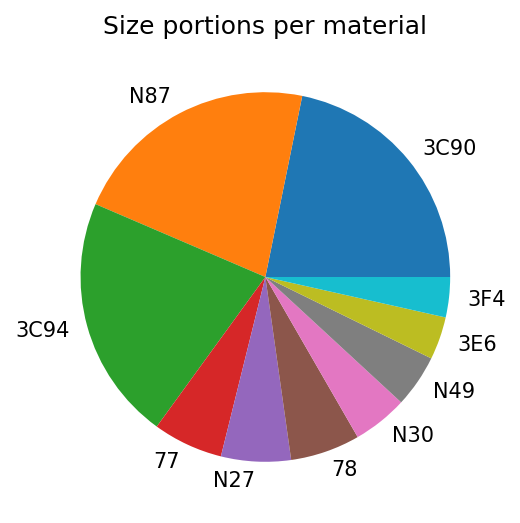

In [149]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.pie(counts_per_mat.to_numpy().ravel(), labels=counts_per_mat.T.index.tolist())
ax.set_title("Size portions per material")
print(len(ds), 'samples')

## Distributions

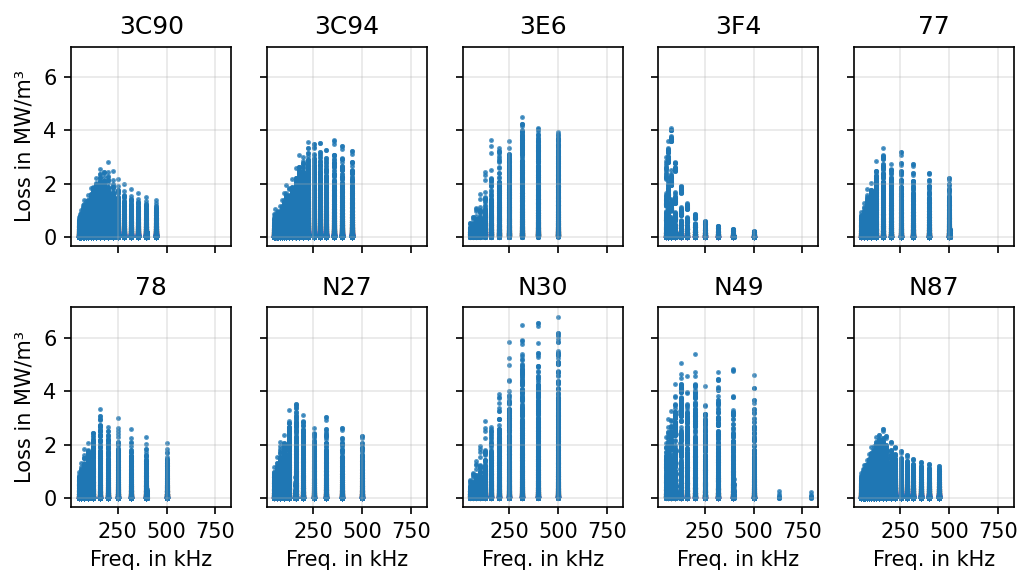

In [74]:
fig, axes = plt.subplots(nrows=2, ncols=5, dpi=150, sharex=True, sharey=True, figsize=(7, 4))
for ax, (mat_lbl, mat_df) in zip(axes.flatten(), ds.groupby("material")):
    ax.scatter(mat_df.freq/1000, mat_df.ploss*1e-6, alpha=.7, s=2.0)
    ax.set_title(mat_lbl)
axes[0, 0].set_ylabel("Loss in MW/m³")
axes[1, 0].set_ylabel("Loss in MW/m³")
for ax in axes[-1, :]:
    ax.set_xlabel("Freq. in kHz")
fig.tight_layout()

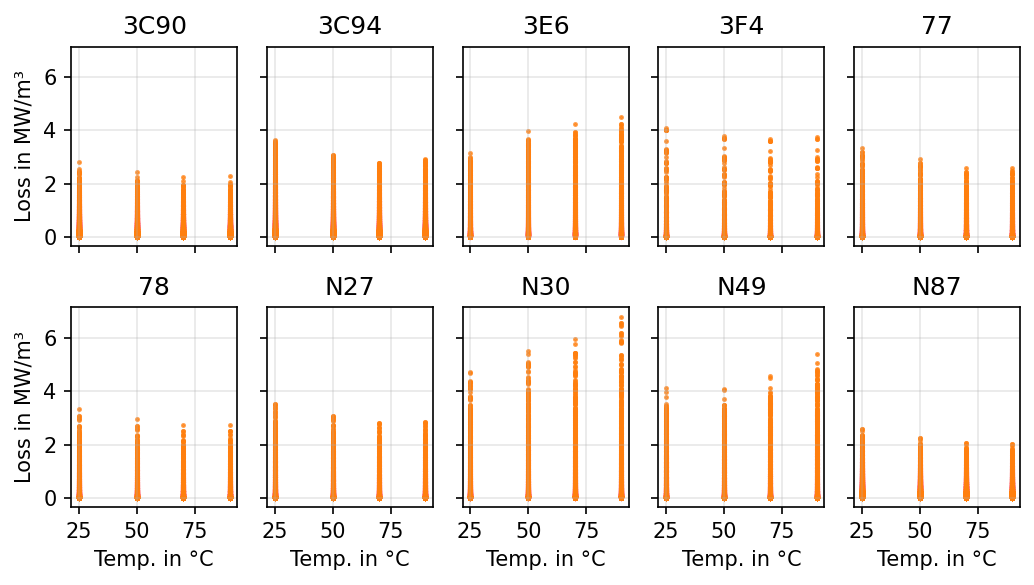

In [75]:
fig, axes = plt.subplots(nrows=2, ncols=5, dpi=150, sharex=True, sharey=True, figsize=(7, 4))
for ax, (mat_lbl, mat_df) in zip(axes.flatten(), ds.groupby("material")):
    ax.scatter(mat_df.temp, mat_df.ploss*1e-6, alpha=.7, s=2.0, color='tab:orange')
    ax.set_title(mat_lbl)
axes[0, 0].set_ylabel("Loss in MW/m³")
axes[1, 0].set_ylabel("Loss in MW/m³")
for ax in axes[-1, :]:
    ax.set_xlabel("Temp. in °C")
fig.tight_layout()

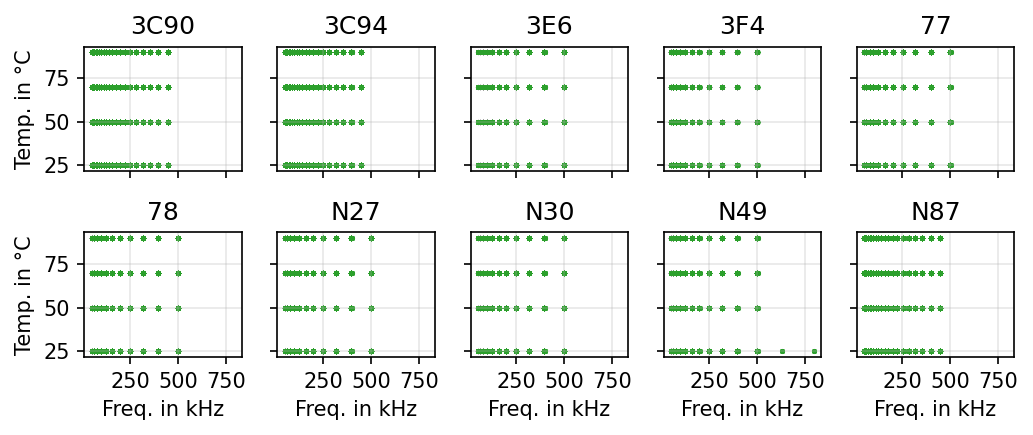

In [78]:
fig, axes = plt.subplots(nrows=2, ncols=5, dpi=150, sharex=True, sharey=True, figsize=(7, 3))
for ax, (mat_lbl, mat_df) in zip(axes.flatten(), ds.groupby("material")):
    ax.scatter(mat_df.freq*1e-3, mat_df.temp, alpha=.7, s=2.0, color='tab:green')
    ax.set_title(mat_lbl)
axes[0, 0].set_ylabel("Temp. in °C")
axes[1, 0].set_ylabel("Temp. in °C")
for ax in axes[-1, :]:
    ax.set_xlabel("Freq. in kHz")
fig.tight_layout()

## Visualize B-H-Curves

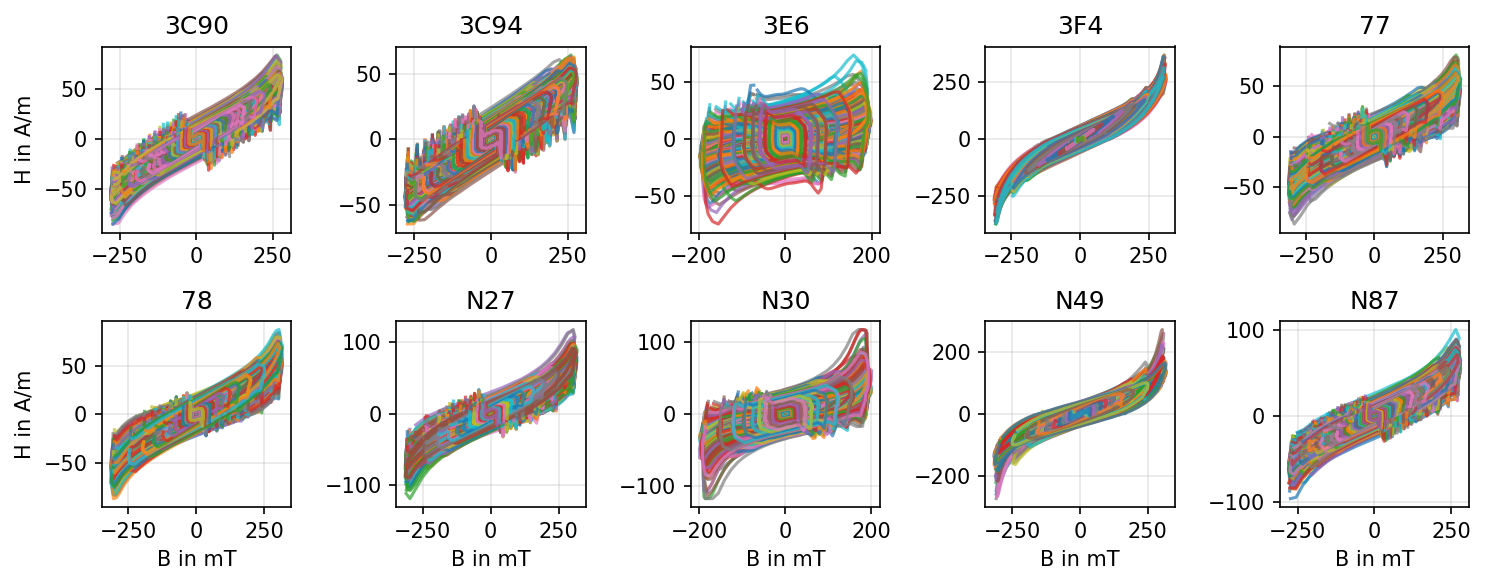

In [90]:
fig, axes = plt.subplots(nrows=2, ncols=5, dpi=150, sharex=False, sharey=False, figsize=(10, 4))
for ax, (mat_lbl, mat_df) in zip(axes.flatten(), ds.groupby("material")):
    b, h = mat_df.loc[:, [f"B_t_{k}" for k in range(0,1024, 4)]].to_numpy(), mat_df.loc[:, [f"H_t_{k}" for k in range(0,1024, 4)]].to_numpy()
    ax.plot(b.T*1000, h.T, alpha=.7)
    ax.set_title(mat_lbl)
axes[0, 0].set_ylabel("H in A/m")
axes[1, 0].set_ylabel("H in A/m")
for ax in axes[-1, :]:
    ax.set_xlabel("B in mT")
fig.tight_layout()

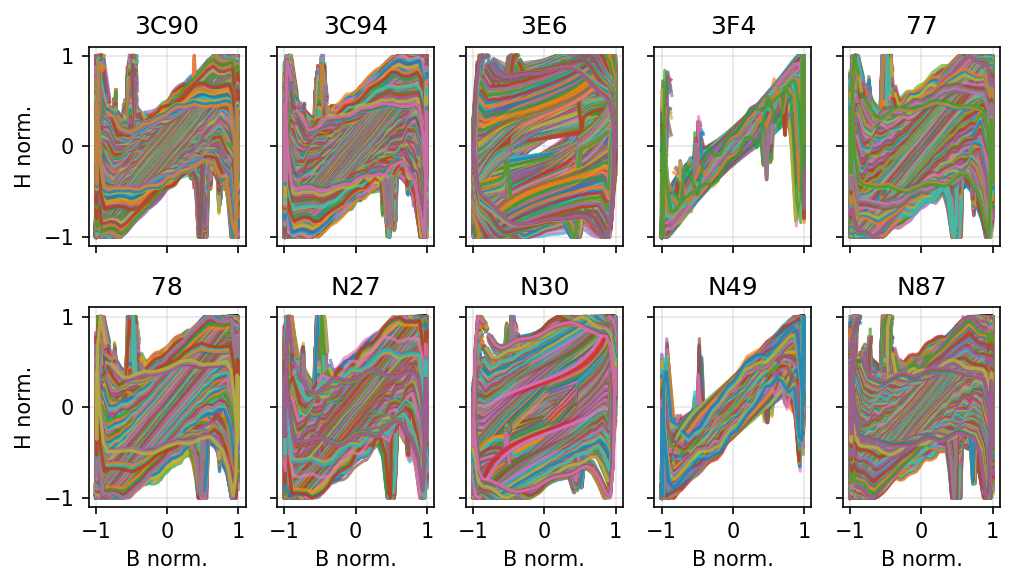

In [93]:
# BH curves normalized on maximum amplitude
fig, axes = plt.subplots(nrows=2, ncols=5, dpi=150, sharex=True, sharey=True, figsize=(7, 4))
for ax, (mat_lbl, mat_df) in zip(axes.flatten(), ds.groupby("material")):
    b, h = mat_df.loc[:, [f"B_t_{k}" for k in range(0,1024, 4)]].to_numpy(), mat_df.loc[:, [f"H_t_{k}" for k in range(0,1024, 4)]].to_numpy()
    ax.plot((b/np.abs(b).max(axis=1).reshape(-1, 1)).T, (h/np.abs(h).max(axis=1).reshape(-1, 1)).T, alpha=.7)
    ax.set_title(mat_lbl)
axes[0, 0].set_ylabel("H norm.")
axes[1, 0].set_ylabel("H norm.")
for ax in axes[-1, :]:
    ax.set_xlabel("B norm.")
fig.tight_layout()

## Distributions (2)
Consider B_max and H_max

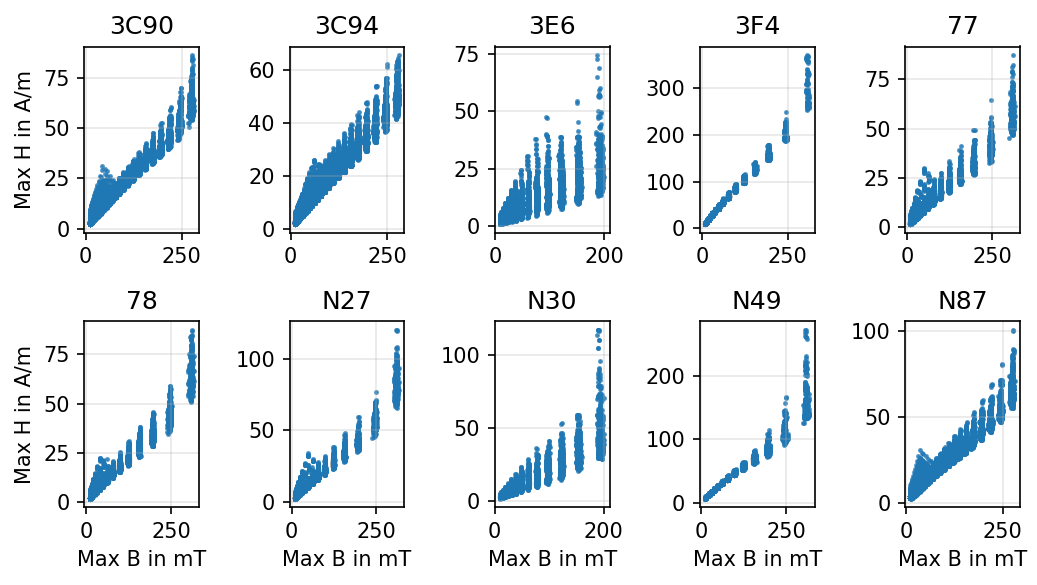

In [99]:
# Max H over B Max
fig, axes = plt.subplots(nrows=2, ncols=5, dpi=150, sharex=False, sharey=False, figsize=(7, 4))
for ax, (mat_lbl, mat_df) in zip(axes.flatten(), ds.groupby("material")):
    b, h = mat_df.loc[:, [f"B_t_{k}" for k in range(0,1024)]].to_numpy(), mat_df.loc[:, [f"H_t_{k}" for k in range(0,1024)]].to_numpy()
    bmax = np.max(np.abs(b), axis=1)
    hmax = np.max(np.abs(h), axis=1)
    ax.scatter(bmax*1000, hmax, alpha=.7, s=2.0)
    ax.set_title(mat_lbl)
axes[0, 0].set_ylabel("Max H in A/m")
axes[1, 0].set_ylabel("Max H in A/m")
for ax in axes[-1, :]:
    ax.set_xlabel("Max B in mT")
fig.tight_layout()

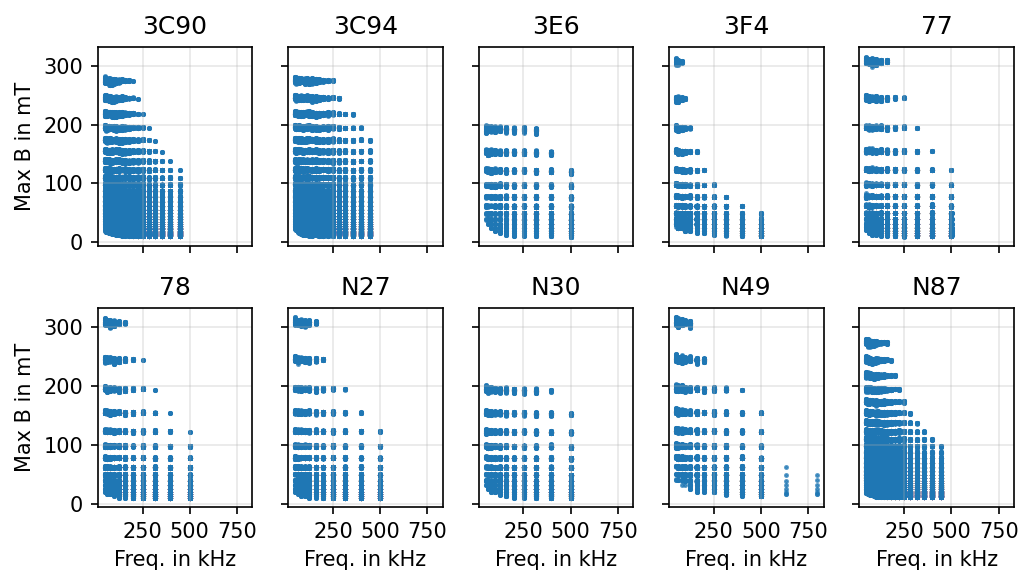

In [110]:
# max B over Frequency
fig, axes = plt.subplots(nrows=2, ncols=5, dpi=150, sharex=True, sharey=True, figsize=(7, 4))
for ax, (mat_lbl, mat_df) in zip(axes.flatten(), ds.groupby("material")):
    b = mat_df.loc[:, [f"B_t_{k}" for k in range(0,1024)]].to_numpy() #, mat_df.loc[:, [f"H_t_{k}" for k in range(0,1024)]].to_numpy()
    bmax = np.max(np.abs(b), axis=1)
    #hmax = np.max(np.abs(h), axis=1)
    #ax.scatter(mat_df.freq*1e3, hmax, alpha=.7, s=2.0, label='H')
    ax.scatter(mat_df.freq*1e-3, bmax*1000, alpha=.7, s=2.0, label='B', )
    ax.set_title(mat_lbl)
axes[0, 0].set_ylabel("Max B in mT")
axes[1, 0].set_ylabel("Max B in mT")
for ax in axes[-1, :]:
    ax.set_xlabel("Freq. in kHz")
fig.tight_layout()

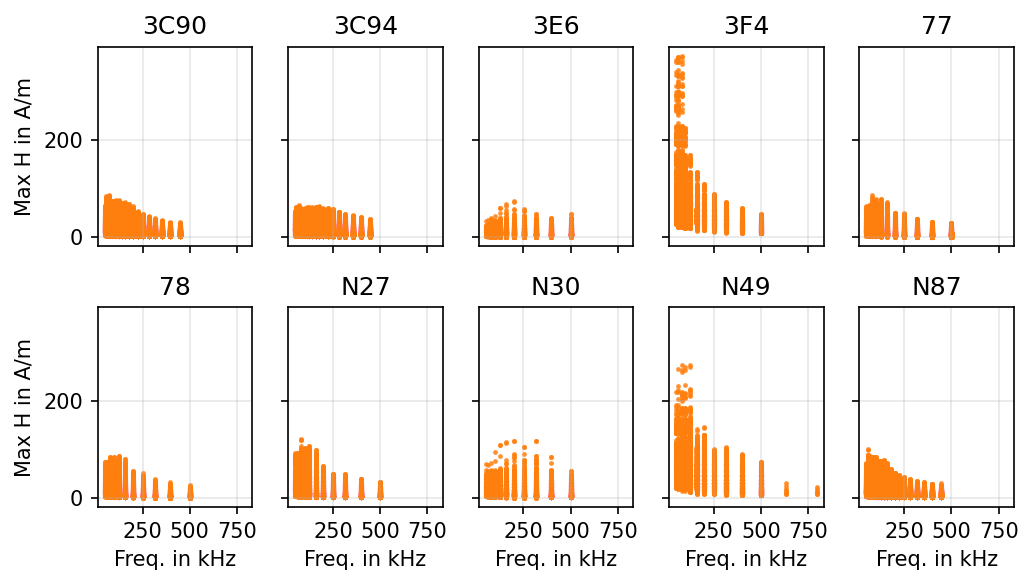

In [112]:
# max H over Frequency
fig, axes = plt.subplots(nrows=2, ncols=5, dpi=150, sharex=True, sharey=True, figsize=(7, 4))
for ax, (mat_lbl, mat_df) in zip(axes.flatten(), ds.groupby("material")):
    h = mat_df.loc[:, [f"H_t_{k}" for k in range(0,1024)]].to_numpy()
    
    hmax = np.max(np.abs(h), axis=1)
    ax.scatter(mat_df.freq*1e-3, hmax, alpha=.7, s=2.0, label='H', color='tab:orange')
    
    ax.set_title(mat_lbl)
axes[0, 0].set_ylabel("Max H in A/m")
axes[1, 0].set_ylabel("Max H in A/m")
for ax in axes[-1, :]:
    ax.set_xlabel("Freq. in kHz")
fig.tight_layout()

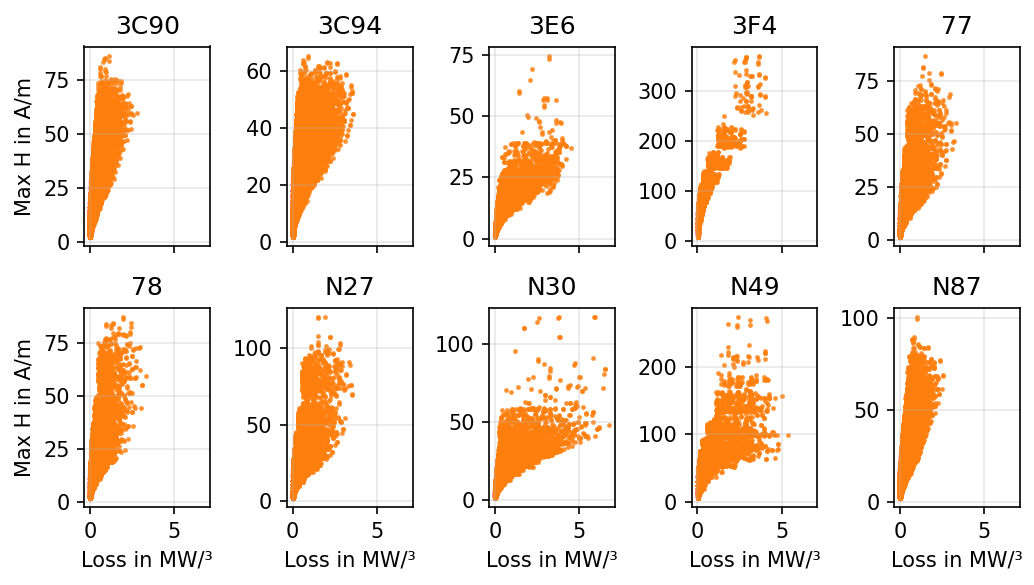

In [114]:
# max H over power loss
fig, axes = plt.subplots(nrows=2, ncols=5, dpi=150, sharex=True, sharey=False, figsize=(7, 4))
for ax, (mat_lbl, mat_df) in zip(axes.flatten(), ds.groupby("material")):
    h = mat_df.loc[:, [f"H_t_{k}" for k in range(0,1024)]].to_numpy()
    
    hmax = np.max(np.abs(h), axis=1)
    ax.scatter(mat_df.ploss*1e-6, hmax, alpha=.7, s=2.0, label='H', color='tab:orange')
    
    ax.set_title(mat_lbl)
axes[0, 0].set_ylabel("Max H in A/m")
axes[1, 0].set_ylabel("Max H in A/m")
for ax in axes[-1, :]:
    ax.set_xlabel("Loss in MW/³")
fig.tight_layout()

## Estimate waveforms

In [81]:
square_sine_template = np.repeat(np.array([1, -1]), 512)
sawtooth_template = np.hstack([np.linspace(-1, 1, 800), np.zeros(224)])
sine_template = np.sin(np.arange(1024)*2*np.pi/1024)
neg_cos_template = -np.cos(np.arange(1024)*2*np.pi/1024)

templates = np.column_stack([square_sine_template, sawtooth_template, sine_template, neg_cos_template]).T

In [170]:
t = np.arange(1024)
#template_lbls = ["square", "saw", "sin", 'neg_cos']
def get_waveform_est():
    """cls_estimate = []
    for bb in b:
        cls_estimate.append(np.argmin(np.mean(np.abs(bb.reshape(1, -1) - templates*bb.max())[:, 100:500], axis=1), axis=0))
    return np.asarray(cls_estimate)"""
    k = np.zeros(full_b.shape[0], dtype=int)
    k[np.all(np.abs(full_b[:, 250:500:50] - full_b[:, 200:450:50]) / np.max(np.abs(full_b), axis=1).reshape(-1, 1) < 0.05, axis=1) & np.all(full_b[:, -200:]< 0, axis=1)] = 1  # square
    B_max_idx = np.argmax(full_b, axis=1)
    k[B_max_idx >= 512] = 2  # saw tooth
    return k
    

ds["waveform"] = get_waveform_est()


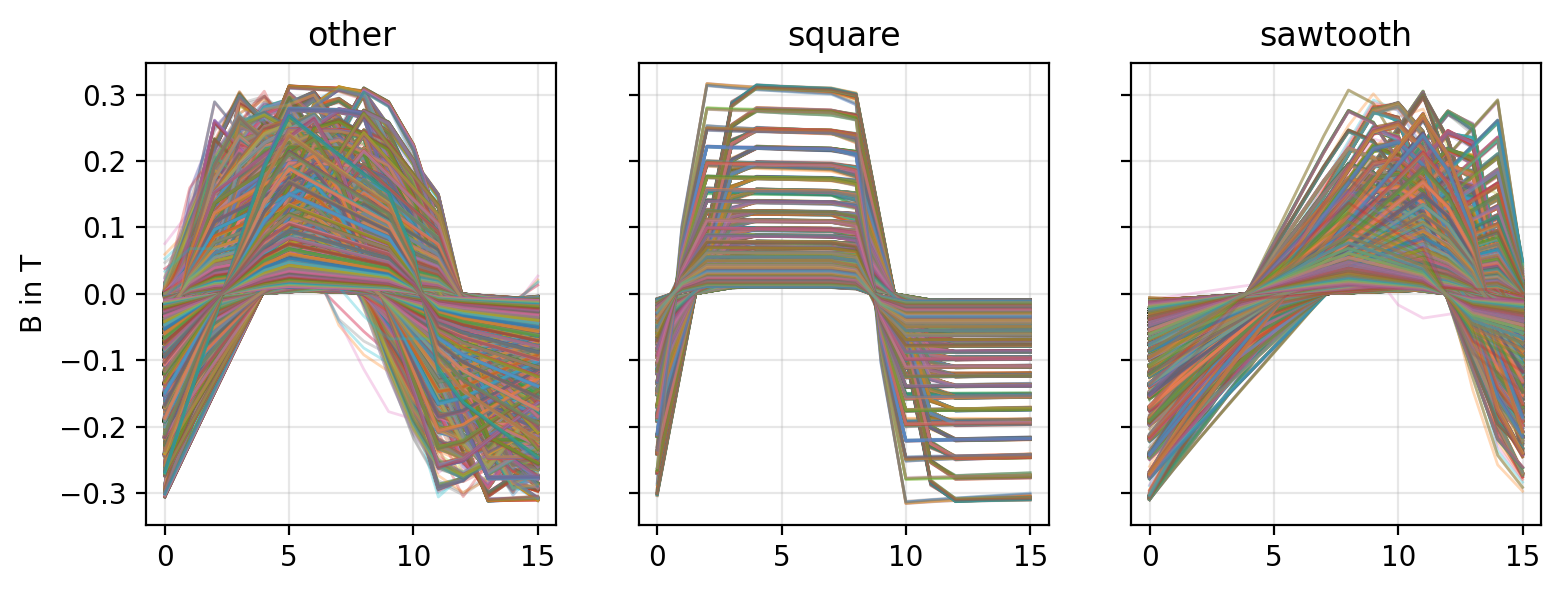

In [164]:
template_lbls = ['other', 'square', 'sawtooth']
fig, axes = plt.subplots(1, len(template_lbls), dpi=200, figsize=(9, 3), sharex=True, sharey=True)

doi = ds#.assign(Bmax=np.abs(full_b).max(axis=1)).query("Bmax < 0.05")
#doi_b = doi.loc[:, [c for c in ds if c.startswith("B_t")]].to_numpy()
doi_b = full_b[:, ::64]  # only 16 samples of period
for i, ax in enumerate(axes):
    ax.plot(doi_b[doi.waveform == i, :].T, alpha=0.3, lw=1.0)

axes[0].set_ylabel("B in T")
for ax in axes:
    ax.set_xlabel("1/Frequency")
for i, lbl in enumerate(template_lbls):
    axes[i].set_title(lbl)

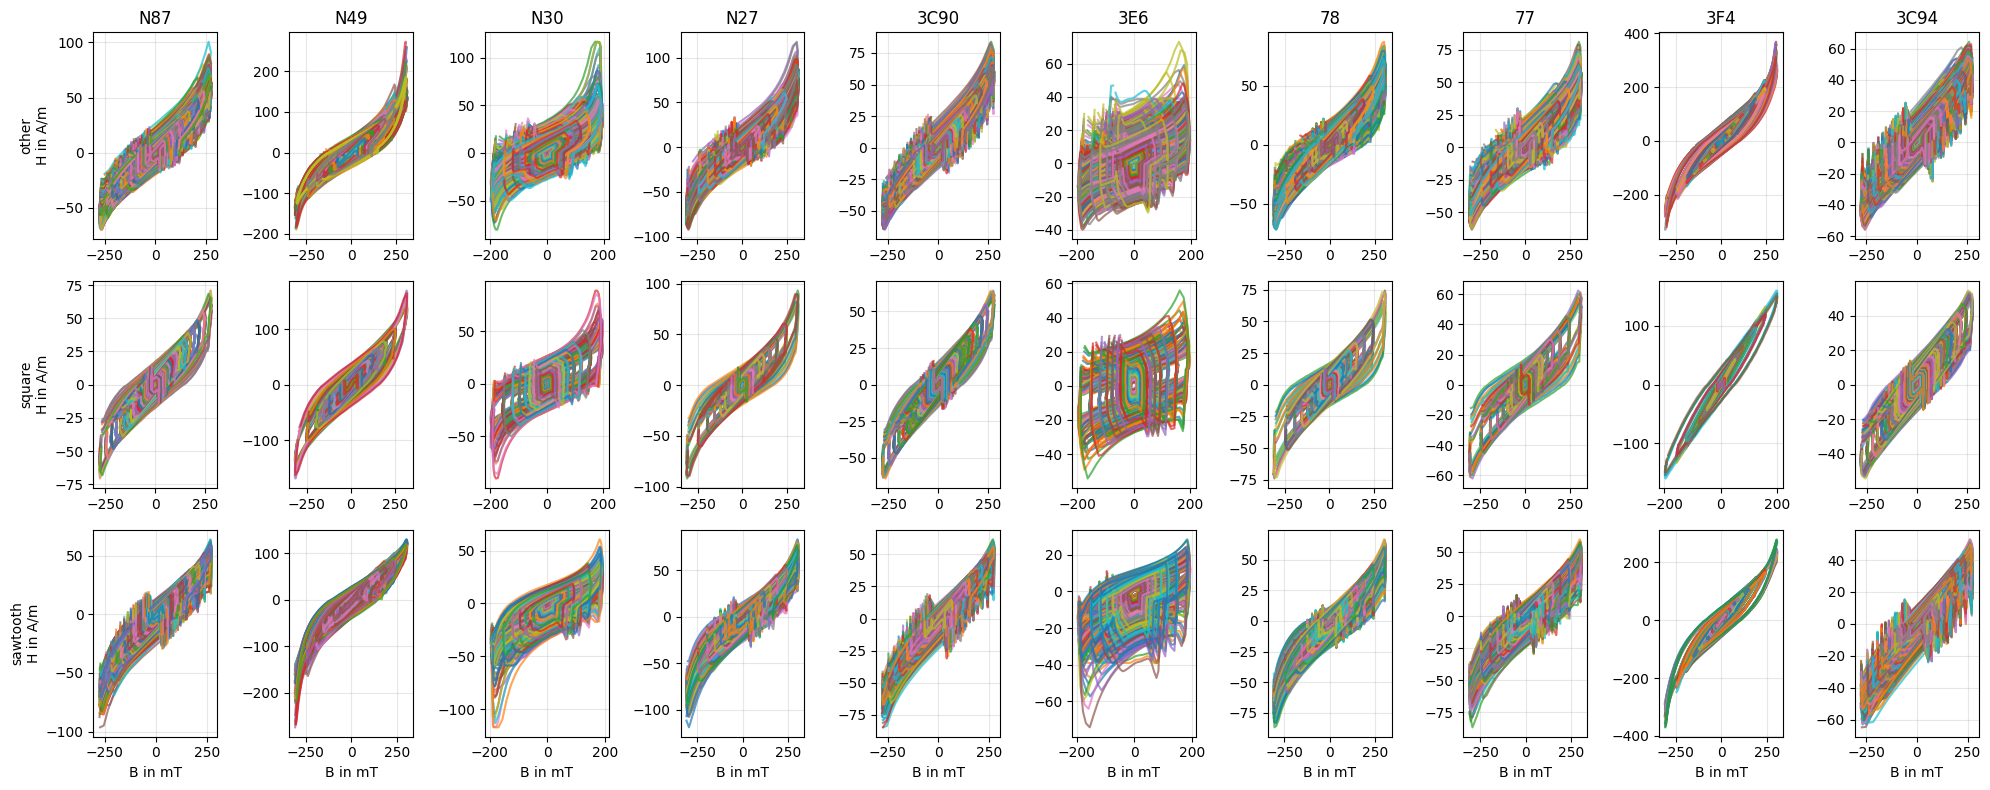

In [177]:
# B-H polygon per material and per waveform
fig, axes = plt.subplots(nrows=len(template_lbls), ncols=10, dpi=100, sharex=False, sharey=False, figsize=(20, 8))
mat_lbls = ds.material.unique().tolist()
for (mat_lbl, wav_lbl), df_ in ds.groupby(["material", 'waveform']):
    b, h = df_.loc[:, [f"B_t_{k}" for k in range(0,1024, 4)]].to_numpy(), df_.loc[:, [f"H_t_{k}" for k in range(0,1024, 4)]].to_numpy()
    col_i = mat_lbls.index(mat_lbl)
    axes[wav_lbl, col_i].plot(b.T*1000, h.T, alpha=.7)
    
for ax, wav_lbl in zip(axes[:, 0], template_lbls):
    ax.set_ylabel(f"{wav_lbl}\nH in A/m")
for ax, m in zip(axes[0, :], mat_lbls):
    ax.set_title(m)
for ax in axes[-1, :]:
    ax.set_xlabel("B in mT")
fig.tight_layout()

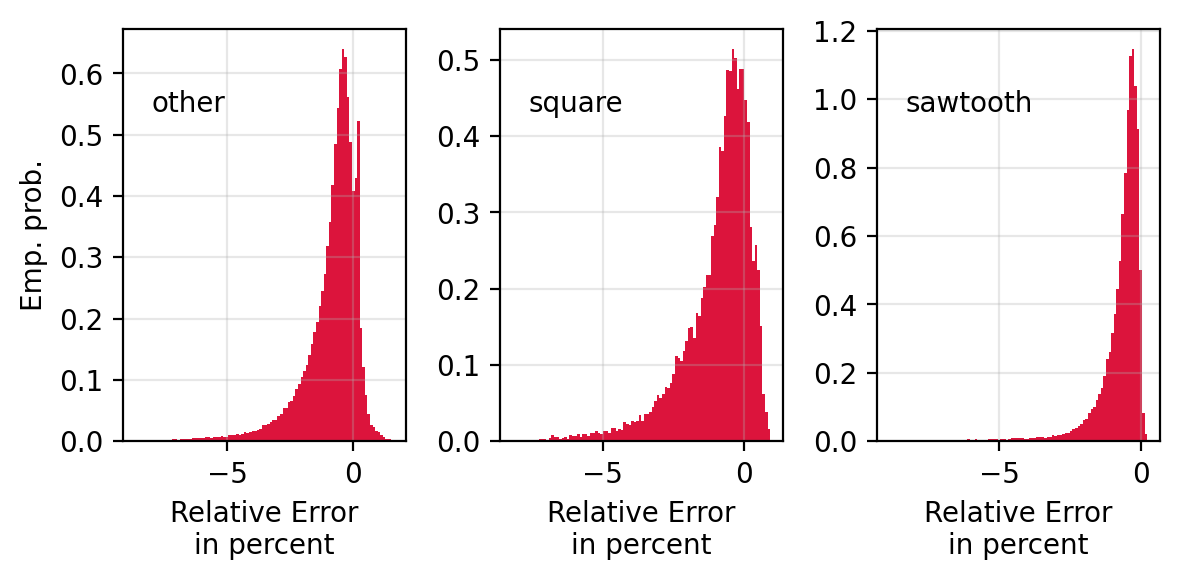

In [168]:
# computed area of the B-H polygon - analysis
fig, axes = plt.subplots(1, len(template_lbls), sharex=False, sharey=False, dpi=200, figsize=(6, 3))
#plt.figure(dpi=200)

ds["computed_bh_area"] = get_bh_integral(ds)
for ax, (mat_lbl, mat_df) in zip(axes.flatten(), ds.groupby("waveform")):    
    calc_error = ( mat_df.computed_bh_area - mat_df.ploss) / mat_df.ploss
    ax.hist(calc_error*100 , color='crimson', bins=100, density=True)
    ax.text(0.1, 0.8, s=template_lbls[int(mat_lbl)], transform=ax.transAxes )
    if ax == axes[0]:
        ax.set_ylabel("Emp. prob.")
    ax.set_xlabel("Relative Error\nin percent")
fig.tight_layout()

Text(0, 0.5, 'Rel. Error in percent')

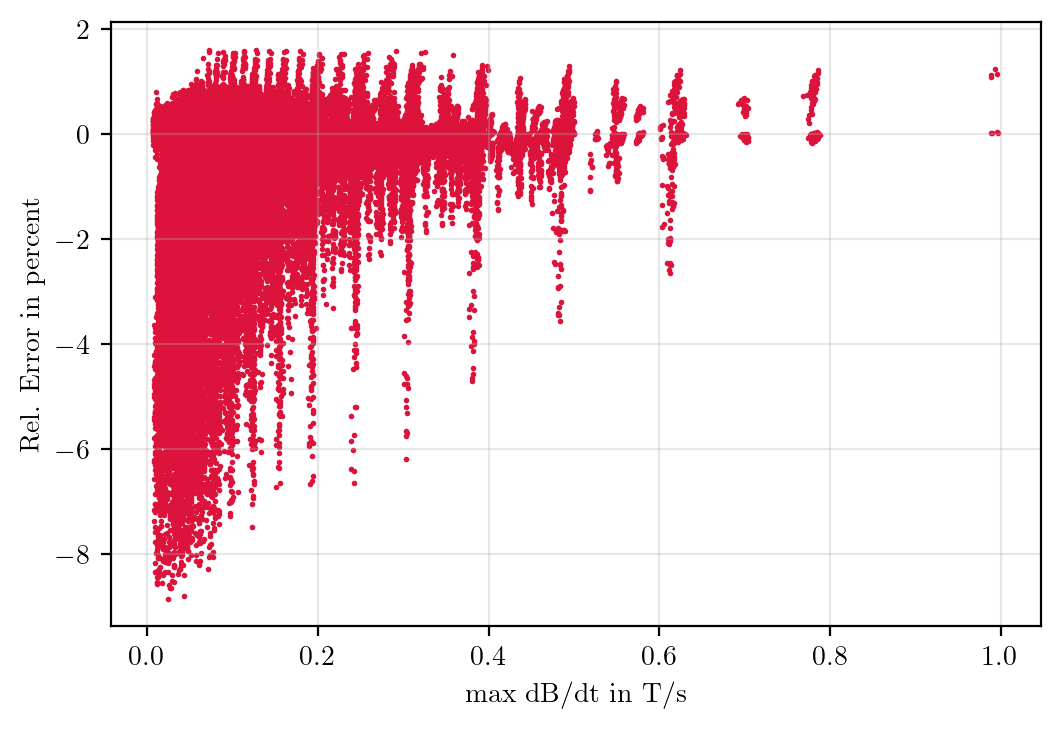

In [10]:
#ds["waveform"] = cls_estimate
ds["computed_bh_area"] = get_bh_integral(ds)
ds["max_dBdt"] = np.abs(b[:, 1:] - b[:, :-1]).max(axis=1)*ds.freq/1024
ds["ploss_rel_error"] = ( ds.computed_bh_area - ds.ploss) / ds.ploss

plt.figure(dpi=150, figsize=(3,3))
plt.scatter(ds.max_dBdt, ds.ploss_rel_error*100, s=1.0, color='crimson')
plt.xlabel("max dB/dt in T/s")
plt.ylabel("Rel. Error in percent")

Text(0, 0.5, 'Rel. Error in percent')

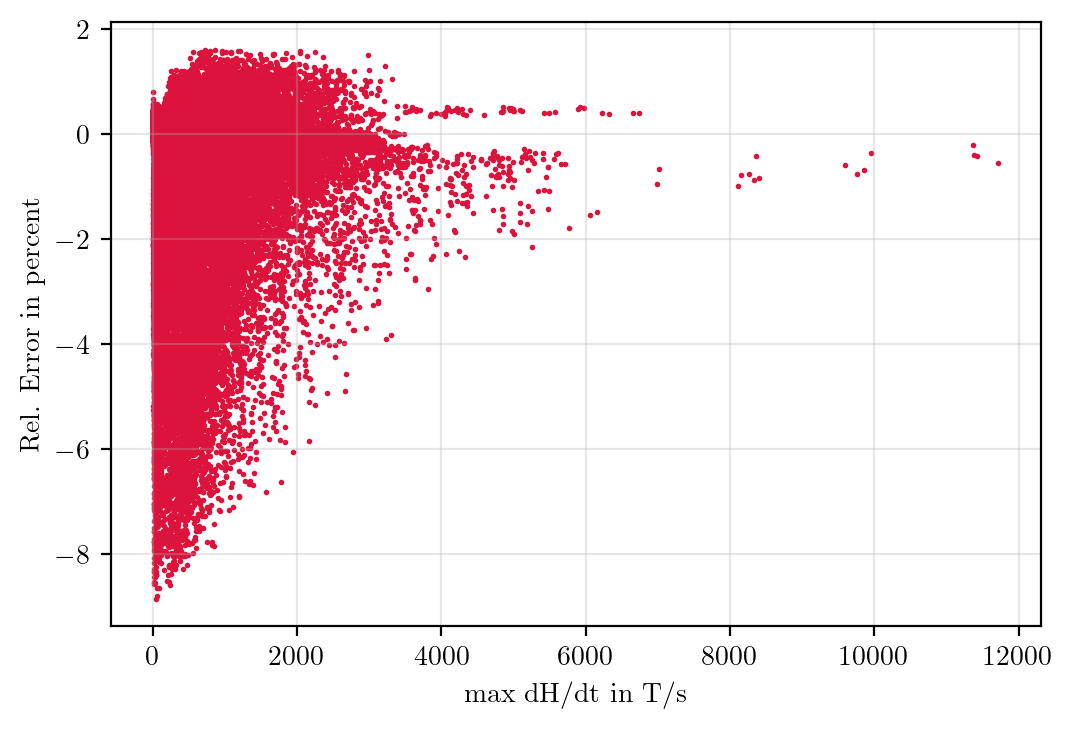

In [11]:
plt.figure(dpi=200)
plt.scatter(np.abs(h[:, 1:] - h[:, :-1]).max(axis=1)*ds.freq/1024, ds.ploss_rel_error*100, s=1.0, color='crimson')
plt.xlabel("max dH/dt in T/s")
plt.ylabel("Rel. Error in percent")

## Visualize Relative Error Ploss vs. Integral B-H

In [115]:

ds["computed_bh_area"] = get_bh_integral(ds)
ds.loc[:, ['ploss', 'computed_bh_area']]

,ploss,computed_bh_area
0,2323.266439,2328.890357
1,3267.161887,3274.076418
2,4427.524958,4436.646285
3,5780.576037,5800.852509
4,8000.416663,8020.701208
...,...,...
186742,130192.516389,130901.153215
186743,163806.431215,164720.400188
186744,206905.659713,208039.252584
186745,257313.520605,258805.000713


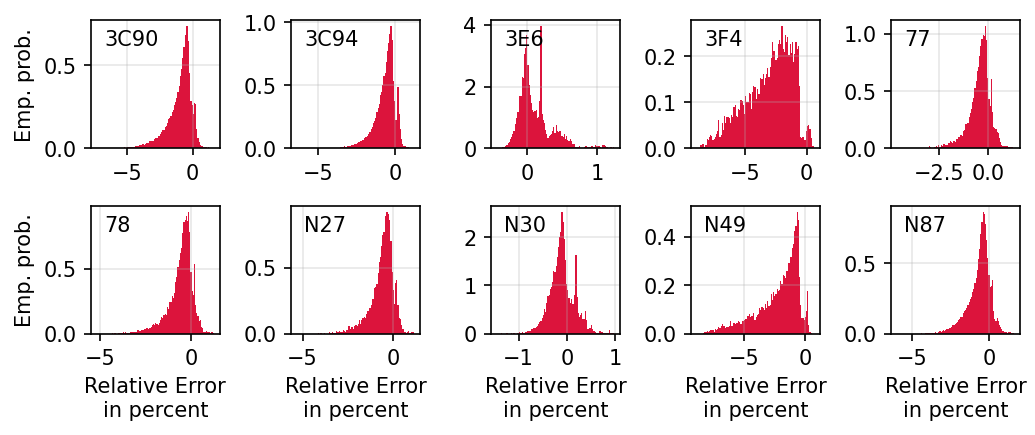

In [117]:
fig, axes = plt.subplots(2, 5, sharex=False, sharey=False, dpi=150, figsize=(7, 3))
#plt.figure(dpi=200)

for ax, (mat_lbl, mat_df) in zip(axes.flatten(), ds.groupby("material")):    
    calc_error = ( mat_df.computed_bh_area - mat_df.ploss) / mat_df.ploss
    ax.hist(calc_error*100 , color='crimson', bins=100, density=True)
    ax.text(0.1, 0.8, s=mat_lbl, transform=ax.transAxes )
    if ax in axes[:, 0]:
        ax.set_ylabel("Emp. prob.")
    if ax in axes[1, :]:
        ax.set_xlabel("Relative Error\nin percent")
fig.tight_layout()

Text(0, 0.5, 'Relative error in percent')

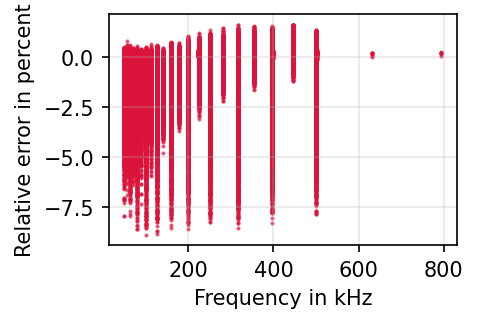

In [123]:
plt.figure(dpi=150, figsize=(3, 2))
plt.scatter(ds.freq*1e-3, ( ds.computed_bh_area - ds.ploss) / ds.ploss*100, color='crimson', s=1, alpha=0.6)
plt.xlabel("Frequency in kHz")
plt.ylabel("Relative error in percent")

Text(0, 0.5, 'Relative error in percent')

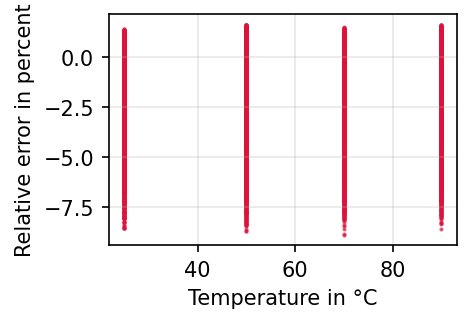

In [122]:
plt.figure(dpi=150, figsize=(3, 2))
plt.scatter(ds.temp, ( ds.computed_bh_area - ds.ploss)/ ds.ploss*100, color='crimson', s=1, alpha=0.6)
plt.xlabel("Temperature in °C")
plt.ylabel("Relative error in percent")

## How hard is predicting the initial/terminal H value?
As a pre analysis for differential equation based methods